<a href="https://colab.research.google.com/github/tonyscan6003/Exercisescripts/blob/master/RE4017_lab_4_2_cnn_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Neural Networks with CIFAR-10 Dataset
In this lab we will train a Convolutional Neural Network to classify the CIFAR10 Dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 10 image categories: "Airplane", "Automobile", Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck".  We will initally train the network and then add dropout regularisation to improve the accuracy and prevent overfitting.

![Cifar10 Data set](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)


As we are training neural networks within the colab window make sure to click on Runtime->Change runtime type and make sure Hardware accelerator is set to GPU.

![alt text](https://learningdeep.net/wp-content/uploads/3.png)





In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras import datasets,layers, models,optimizers
import matplotlib.pyplot as plt

print(tf.__version__)




2.2.0-rc2


# Load Dataset.
The CIFAR-10 dataset consists of colour image patches of (32 x 32 x 3). We can load the dataset directly from Tensorflow TFDS https://www.tensorflow.org/datasets/overview.

We futher process the raw datasets, adjusting the input range from {0,255} to {-0.5,0.5}. We can also convert the labels to their one hot representation. We also can setup the batch size.


In [0]:
batch_size = 32


In [0]:
# We initally load the raw training/test dataset
ds, info = tfds.load('cifar10', shuffle_files=True, with_info=True)
num_train_examples= info.splits['train'].num_examples
num_test_examples= info.splits['test'].num_examples
raw_train,raw_test = ds['train'],ds['test']

In [0]:
# List of functions that we can apply to the dataset before sending to network for training
def convert(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image-0.5
  label = tf.squeeze(tf.one_hot(label, 10)) # Convert label to one-hot 
  return image,label

def gen_tr_datasets(src_dataset):    
    # Define Datasets 
    src_dataset = src_dataset.shuffle(num_train_examples) 
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    tr_dataset = tr_dataset.map(convert)
    tr_dataset = tr_dataset.batch(batch_size) 
    return tr_dataset

def gen_val_datasets(src_dataset): 
    # Define Datasets 
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    test_dataset = test_dataset.map(convert)
    test_dataset = test_dataset.batch(batch_size) 
    return test_dataset

In [0]:
# Update the datasets
tr_dataset = gen_tr_datasets(raw_train)
test_dataset = gen_val_datasets(raw_test)

Plot some examples from the Training dataset.

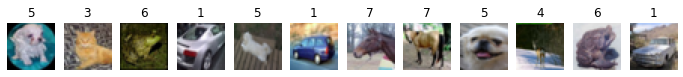

In [8]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(12,10))

for image, label in tr_dataset.take(n_plots):  # Only take a single example
  #print(label.numpy()[0])
  axarr[i].imshow(image[0,:,:,:]+0.5)
  axarr[i].axis('off')
  axarr[i].title.set_text(label.numpy()[0].argmax(axis=-1))
  i = i+1




#Building the Network
In the first lab we created a simple fully connected network from two hidden layers, which was capable of classifying the MNIST dataset with high accuracy. The CIFAR-10 data is more complex therefore in this lab we will build a network with convolution and pooling layers and also add fully connected layers at the end to form a classifier. 

![alt text](https://github.com/tonyscan6003/RE4017/blob/master/images/nn_diagrams-Page-15%20(3).jpg?raw=true)

Notes: 



> Every keras model must start with the statement: model = `models.Sequential()`

> We can add a convolution layer with N kernels (or channels) of size k x k, the padding will be automatically added with padding = 'same' to keep the output of the convolution the same size as the input. `model.add(layers.Conv2D(N, (k, k), activation='relu',padding='same', input_shape=(32, 32, 3)))` The first convolution layer (only) must contain also the statement giving the size of the input images: input_shape = (32,32,3)

> Max Pooling layers are added by `model.add(layers.MaxPooling2D((2, 2)))`(these layers have an implict stride of same as pool size, therefore for pool size (p x p) = (2 x 2) the stride is 2) 

> Dropout layers are added after the pooling layer` model.add(layers.Dropout(0.2))`

> We must add a flatten layer `model.add(layers.Flatten())` before the fully connected (dense layers) to convert the output feature maps from the pooling layers to a 1D vector that can be connected to the fully connected layers.

> Dense layers with N neurons as are added 
`model.add(layers.Dense(N, activation='relu'))`

> The last layer in multi classification, must use softmax activation to output probabilities for multiple classes.
`model.add(layers.Dense(10, activation='softmax'))`

















 





 






In [0]:
# Model Declaration
model = models.Sequential()

# 1st Convolutional Layer 32 kernels, (3,3) kernel size
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 3)))
# 1st Max Pooling Layer (2,2) pooling (automatically stride = 2)
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional Layer 64 kernels, (3,3) kernel size.
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
# 2nd Max Pooling Layer (2,2) pooling (automatically stride = 2)
model.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional Layer 64 kernels, (3,3) kernel size.
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
# 3rd Max Pooling Layer (2,2) pooling (automatically stride = 2)
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer required before dense layers.
model.add(layers.Flatten())
#Dense Layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

 # Training the network SVM
 As in the previous lab we will use the Keras Compile and fit functions to train the network. We can use the same Categorical Crossentropy loss function and the (stocastic) gradient descent optimiser. 

In [0]:
# Comile the model (incudues choosing optimiser and loss function)
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [0]:
history = model.fit(tr_dataset, epochs=30, validation_data=(test_dataset))

After training we can evaluate the model and also plot the model accuracy and value of the loss function during training (Run the code cell below to create the plots). In the generated plots we we see the accuracy and loss for both the training and validation datasets.

 It should be clear from the plots and results that overtraining is occuring.  The accuracy of the training data is very high while the performance on the validation set stops increasing and even reduces.

In order to prevent overfitting we need to use some the techniques that we listed at the end of lecture 4_2. The general catch all term for these techniques is "regularisation". (True regularisation is adding a penalty to the loss function but all techniques can have a regularising effect i.e. prevent overfitting). We don't need to use all the techniques together as that could result in the opposite occuring and now the neural network would tend to underfit the training data. The goal is to choose just enough regularisation to have the network just about on the edge of overfitting. This will give us good results with the validation set. It normally takes some experimentation to choose the right regularisation technique, for this lab we will replace the model with the one at this link. https://github.com/tonyscan6003/RE4017/blob/master/cnn_model 

The revised model has dropout layers after each of the pooling layers and also applies regularisation in the convolution layers. If you re-run the compile and training steps with the new model, the plots you obtain should show that the model is no longer overfitting during training. An increase in accuracy with the validation set is also obtained (you may wish to increase the number of epochs in the `model.fit` command to 40 to allow higher accuracy to be reached). This modified model can achieve approximately 80% accuray on CIFAR-10. It is possible to achieve higher accuracy by futher optimising the neural network.

In [0]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Model Accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

# Testing the Network
We will view some predictions from the test dataset. Incorrect labels are marked in red.

In [0]:
y_pred = model.predict(test_dataset)
y_class_label = y_pred.argmax(axis=-1)


In [0]:
fig = plt.figure(figsize=(20, 10))

i=0
for image, label in test_dataset.take(1):  # Only take a single batch
  for i in range(batch_size):
     ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
     ax.imshow(image[i,:,:,:]+0.5)
     ax.axis('off')
     color = ('black' if y_class_label[i] == label.numpy()[i,:].argmax(axis=-1) else 'red')
     ax.set_title(y_class_label[i],color=color)
     i = i+1



